In [1]:
# default_exp transformer

In [2]:
# all_func


# Transformer Embeddings

> Functions to train and evaluate ML models on embeddings from a pretrained Transformer.

In [3]:
# export

from peptide.imports import *
from peptide.basics import *
from peptide.utils import *
from peptide.learn import Learner
from peptide.data import (
    ACPDataset,
    AMPDataset,
    DNABindDataset,
)

## Load Data

In [4]:
acp_data = ACPDataset(DATA_STORE)
amp_data = AMPDataset(DATA_STORE)
dna_data = DNABindDataset(DATA_STORE, max_seq_len=300)

## Pretrained Model - ESM

Details of the pretrained model:

Evolutionary Scale Modeling (ESM)
- Transformer protein language models.
- https://github.com/facebookresearch/esm

### fasta + BioPython

- Details about generating fasta files using the BioPython library is [detailed here in the data module](/peptide/data.html#ProteinDataset.generate_fasta_files).
- fasta files are created by the `generate_fasta_files()` method in the dataset classes for example - `acp_data.generate_fasta_files()`

ESM has a max sequence length limitation of 1024. So `max_seq_len <= 1024` must be used when generating fasta files. 

```python
dna_data.generate_fasta_files(use_seq_max_len=True)
```

### Create Transformer Embeddings From fasta

In order to cerate embeddings in bulk from fasta files [details here](https://github.com/facebookresearch/esm#compute-embeddings-in-bulk-from-fasta-) ..
- the [ESM Github repo](https://github.com/facebookresearch/esm) needs to be cloned
- a conda environment for it needs to be created as detailed in the repo (link above)
- then in that conda environment at the root of the cloned repo, the following commands need to be run

Sample python commands to generate embeddings from pretrained model in the ESM codebase are as follows:

**ACP**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/acp/fasta/acp_train.fasta  ~/.peptide/datasets/acp/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/acp/fasta/acp_train.fasta with 1378 sequences
Processing 1 of 10 batches (292 sequences)
Processing 2 of 10 batches (215 sequences)
Processing 3 of 10 batches (178 sequences)
Processing 4 of 10 batches (157 sequences)
Processing 5 of 10 batches (132 sequences)
Processing 6 of 10 batches (117 sequences)
Processing 7 of 10 batches (105 sequences)
Processing 8 of 10 batches (91 sequences)
Processing 9 of 10 batches (80 sequences)
Processing 10 of 10 batches (11 sequences)
```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/acp/fasta/acp_test.fasta  ~/.peptide/datasets/acp/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/acp/fasta/acp_test.fasta with 344 sequences
Processing 1 of 3 batches (175 sequences)
Processing 2 of 3 batches (113 sequences)
Processing 3 of 3 batches (56 sequences)
```

**AMP**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/amp/fasta/amp_train.fasta  ~/.peptide/datasets/amp/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/amp/fasta/amp_train.fasta with 3234 sequences
Processing 1 of 30 batches (273 sequences)
Processing 2 of 30 batches (240 sequences)
...
Processing 29 of 30 batches (24 sequences)
Processing 30 of 30 batches (1 sequences)
```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/amp/fasta/amp_test.fasta  ~/.peptide/datasets/amp/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/amp/fasta/amp_test.fasta with 808 sequences
Processing 1 of 9 batches (204 sequences)
Processing 2 of 9 batches (157 sequences)
...
Processing 9 of 9 batches (3 sequences)
```

**DNA Binding**
- Train
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_train_seqlen_1024.fasta  ~/.peptide/datasets/dna/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_train_seqlen_1024.fasta with 14189 sequences
Processing 1 of 1525 batches (67 sequences)
Processing 2 of 1525 batches (64 sequences)
```
- Whereas the following results in a max seq length error
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_train.fasta  ~/.peptide/datasets/dna/transformer/train/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_train.fasta with 14189 sequences
Processing 1 of 1641 batches (67 sequences)
...

```
- Test
```sh
python scripts/extract.py esm1b_t33_650M_UR50S ~/.peptide/datasets/dna/fasta/dna_test.fasta  ~/.peptide/datasets/dna/transformer/test/ \
    --repr_layers 0 32 33 --include mean
Transferred model to GPU
Read /home/vinod/.peptide/datasets/dna/fasta/dna_test.fasta with 2272 sequences
Processing 1 of 289 batches (56 sequences)
...

```

### Read Transformer Embeddings
The procedure for reading the embeddings generated from the pretrained ESM model is [detailed here in the data module](/peptide/data.html#ProteinDataset.get_transformer_emb).

## Anti Cancer Peptide Dataset (ACP)

### ACP - Dimensionality Reduction (PCA) vs Full Data

In [5]:
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1378, 1280), (1378,), (344, 1280), (344,))

In [6]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.29824904 0.14635678 0.12145303 0.04919976 0.03232023 0.0283162
 0.02327276 0.01859283 0.01663858 0.01532567]


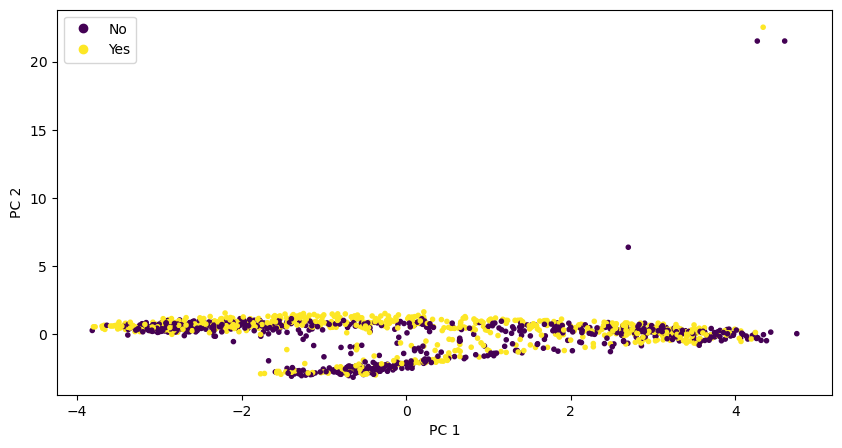

In [7]:
visualize_2pcs(X_train_pca, y_train)

Looks like scaling is needed

In [8]:
scaler = StandardScaler()
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (1378, 50)
Explained variance ratio of the first 10 principal components:
[0.21964568 0.14547494 0.06084786 0.04262355 0.03878562 0.03216276
 0.02793843 0.02416831 0.02228705 0.02031214]


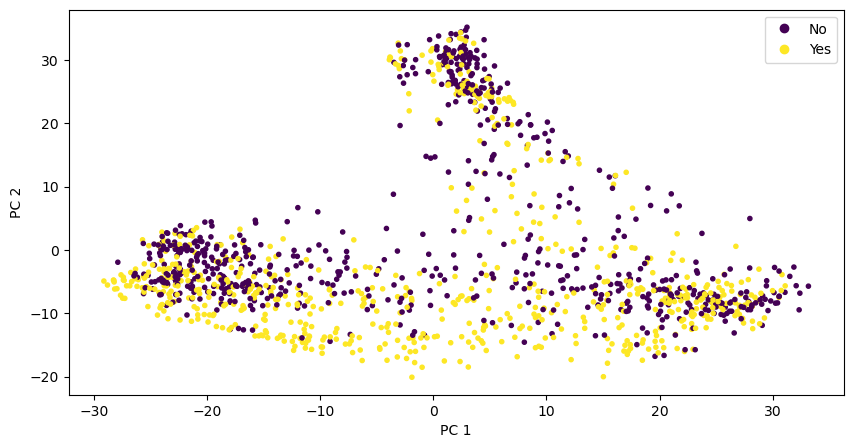

In [9]:
visualize_2pcs(X_train_pca, y_train)

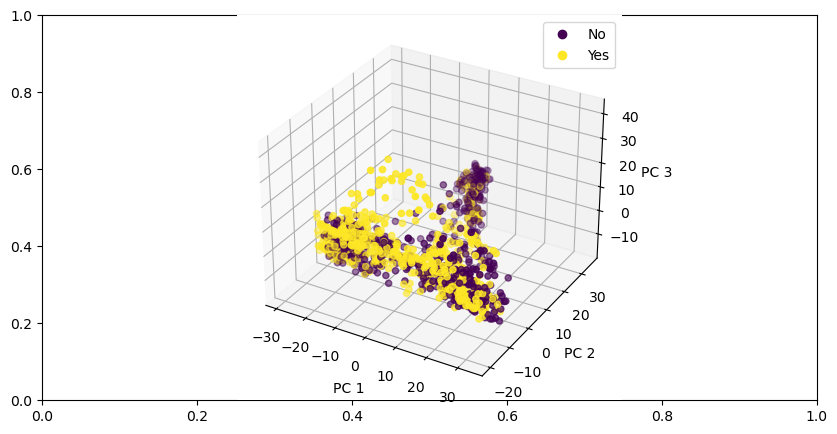

In [10]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [11]:
train_predict(X_train, y_train, X_test, y_test)

/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.726744,0.75,0.716667,0.732955
svc,0.729651,0.75,0.720670,0.735043
xgb,0.729651,0.75,0.720670,0.735043


Evaluation on reduced data

In [12]:
X_test_pca = pca.transform(scaler.transform(X_test))
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.645349,0.656977,0.642045,0.649425
svc,0.654070,0.680233,0.646409,0.662890
xgb,0.726744,0.744186,0.719101,0.731429


### ACP - Get Data and Learners (Layer 33 vs Layer 32)

Layer 33 is the final layer in the ESM model. Here we read data (embeddings) from layer 33 and 32 and initialize learners to run training and prediction on both. 
- Get data using the `ACPDataset` object
- Initialize / instantiate a `Learner` object using 

In [13]:
# layer 33
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta')
acp_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 
# layer 32
X_train, y_train, X_test, y_test = acp_data.get_transformer_emb('acp_train.fasta', 'acp_test.fasta', emb_layer=32)
acp_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### ACP - Grid Search (Supervised Learning)

In [14]:
acp_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [15]:
#hide_output

_, _ = acp_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [16]:
acp_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [17]:
#hide_output

_, _ = acp_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### ACP - Label Spreading (Semi Supervised Learning)

In [18]:
acp_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       172
           1       0.68      0.78      0.73       172

    accuracy                           0.71       344
   macro avg       0.71      0.71      0.71       344
weighted avg       0.71      0.71      0.71       344



In [19]:
acp_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       172
           1       0.72      0.74      0.73       172

    accuracy                           0.72       344
   macro avg       0.72      0.72      0.72       344
weighted avg       0.72      0.72      0.72       344



### ACP - Prediction Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [20]:
acp_lyr33_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=100.0, max...",0.648256,0.662791,0.644068,0.653295
LinearSVC,"{'classifier': LinearSVC(C=0.01, loss='hinge',...",0.680233,0.697674,0.674157,0.685714
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.72093,0.744186,0.711111,0.727273
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.709302,0.784884,0.681818,0.72973


In [21]:
acp_lyr32_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.648256,0.645349,0.649123,0.64723
LinearSVC,"{'classifier': LinearSVC(C=0.1, max_iter=10000...",0.645349,0.645349,0.645349,0.645349
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.709302,0.744186,0.695652,0.719101
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.723837,0.744186,0.715084,0.729345


Save results.

In [22]:
acp_lyr33_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/acp_transformer_lyr33_learner.csv')
acp_lyr32_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/acp_transformer_lyr32_learner.csv')

### ACP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.20614224672317505
n_clusters: 3 -- avg silhouette score: 0.2678729295730591
n_clusters: 4 -- avg silhouette score: 0.2297622412443161
n_clusters: 5 -- avg silhouette score: 0.21765144169330597
n_clusters: 6 -- avg silhouette score: 0.19339945912361145
n_clusters: 7 -- avg silhouette score: 0.15559835731983185
n_clusters: 8 -- avg silhouette score: 0.15815068781375885
n_clusters: 9 -- avg silhouette score: 0.14608792960643768
n_clusters: 10 -- avg silhouette score: 0.14959701895713806


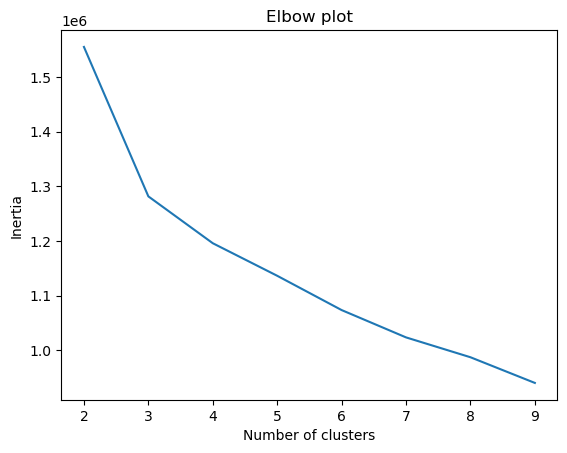

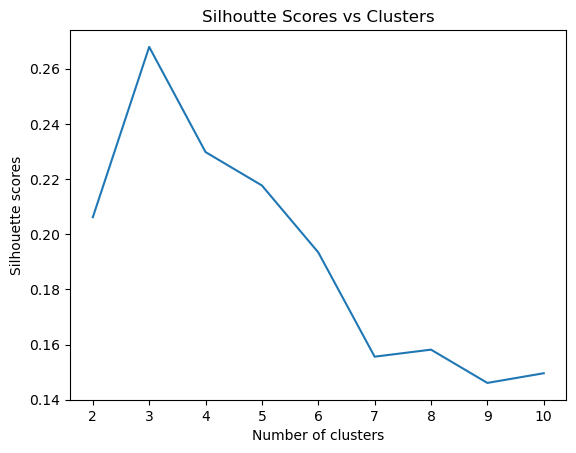

In [23]:
X_pca = acp_lyr33_learner.pick_k()

Cluster counts: Counter({0: 607, 3: 399, 1: 372, 2: 344})


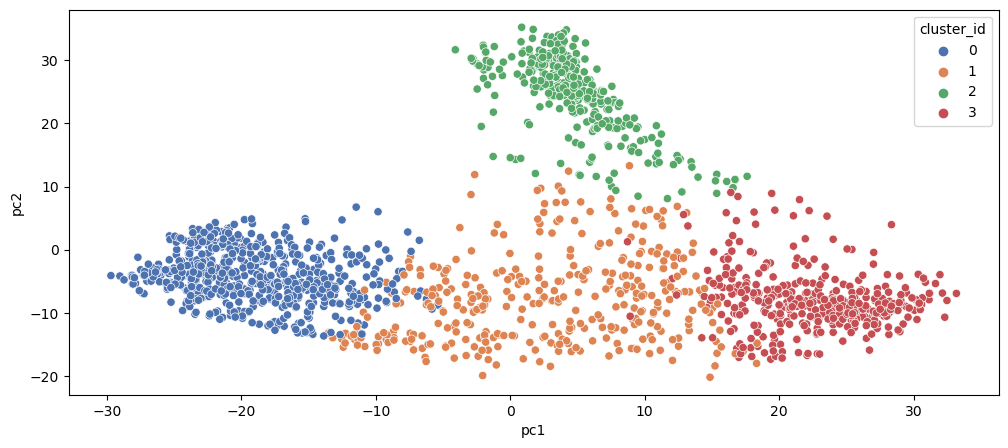

In [24]:
acp_lyr33_learner.analyze_clusters(X_pca, k=4)

## Antimicrobial Peptide Dataset (AMP)

### AMP - PCA vs Full Data

In [25]:
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3234, 1280), (3234,), (808, 1280), (808,))

In [26]:
scaler = StandardScaler()
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train))
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (3234, 50)
Explained variance ratio of the first 10 principal components:
[0.19676162 0.08489581 0.06348867 0.03493932 0.03121493 0.02762624
 0.02619585 0.02370694 0.01980742 0.01853633]


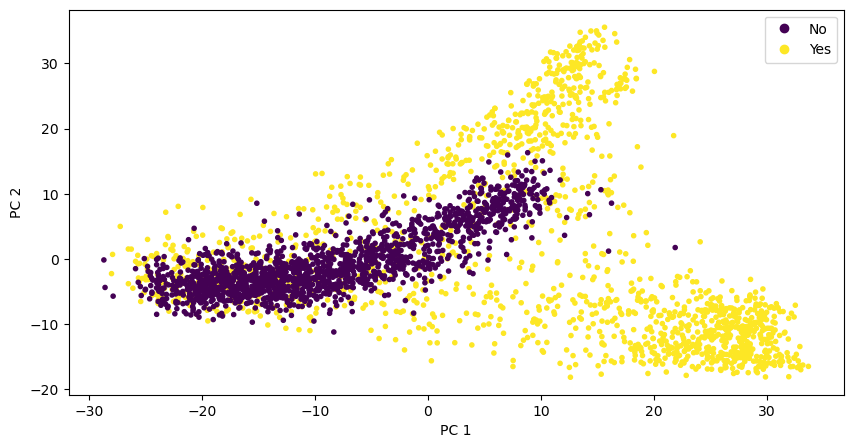

In [27]:
visualize_2pcs(X_train_pca, y_train)

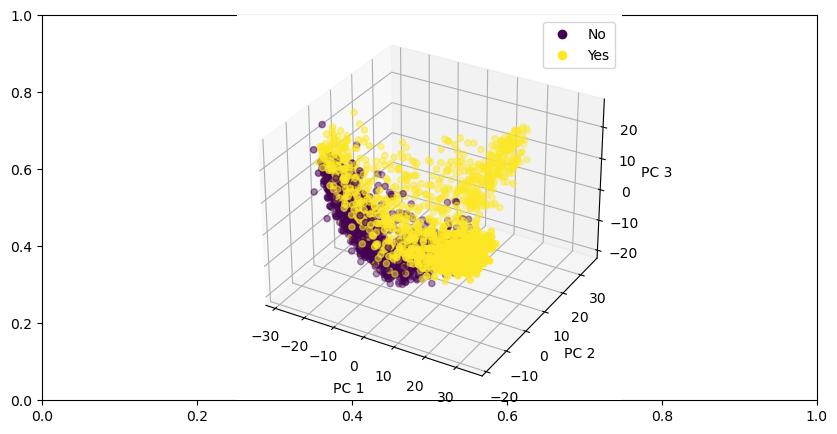

In [28]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [29]:
train_predict(X_train, y_train, X_test, y_test)

,acc,recall,precision,f1
lr,0.935644,0.909320,0.957560,0.932817
svc,0.936881,0.926952,0.943590,0.935197
xgb,0.938119,0.916877,0.955381,0.935733


Evaluation on reduced data

In [30]:
X_test_pca = pca.transform(scaler.transform(X_test))
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.934406,0.909320,0.955026,0.931613
svc,0.931931,0.896725,0.962162,0.928292
xgb,0.943069,0.911839,0.970509,0.940260


### AMP - Get Data and Learners (Layer 33 vs Layer 32)

In [31]:
# layer 33 (default)
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta')
amp_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

# layer 32
X_train, y_train, X_test, y_test = amp_data.get_transformer_emb('amp_train.fasta', 'amp_test.fasta', emb_layer=32)
amp_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### AMP - Grid Search (Supervised Learning)

In [32]:
amp_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [33]:
#hide_output

_, _ = amp_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [34]:
amp_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [35]:
#hide_output

_, _ = amp_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### AMP - Label Spreading (Semi Supervised Learning)

In [36]:
amp_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       411
           1       0.97      0.88      0.92       397

    accuracy                           0.93       808
   macro avg       0.93      0.93      0.93       808
weighted avg       0.93      0.93      0.93       808



In [37]:
amp_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       411
           1       0.95      0.88      0.91       397

    accuracy                           0.92       808
   macro avg       0.92      0.92      0.92       808
weighted avg       0.92      0.92      0.92       808



#### AMP - Prediction Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [38]:
amp_lyr33_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.929455,0.894207,0.959459,0.925684
LinearSVC,"{'classifier': LinearSVC(C=10.0, loss='hinge',...",0.92698,0.904282,0.944737,0.924067
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.938119,0.901763,0.97019,0.934726
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.929455,0.884131,0.969613,0.924901


In [39]:
amp_lyr32_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.924505,0.881612,0.961538,0.919842
LinearSVC,"{'classifier': LinearSVC(C=0.01, loss='hinge',...",0.924505,0.88665,0.956522,0.920261
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.935644,0.901763,0.96496,0.932292
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.918317,0.879093,0.950954,0.913613


Save results.

In [40]:
amp_lyr33_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/amp_transformer_lyr33_learner.csv')
amp_lyr32_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/amp_transformer_lyr32_learner.csv')

### AMP - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.19373548030853271
n_clusters: 3 -- avg silhouette score: 0.21837416291236877
n_clusters: 4 -- avg silhouette score: 0.187213733792305
n_clusters: 5 -- avg silhouette score: 0.1776735484600067
n_clusters: 6 -- avg silhouette score: 0.17970021069049835
n_clusters: 7 -- avg silhouette score: 0.1797829568386078
n_clusters: 8 -- avg silhouette score: 0.1493576169013977
n_clusters: 9 -- avg silhouette score: 0.12389330565929413
n_clusters: 10 -- avg silhouette score: 0.1260935217142105


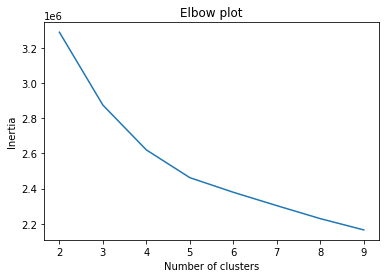

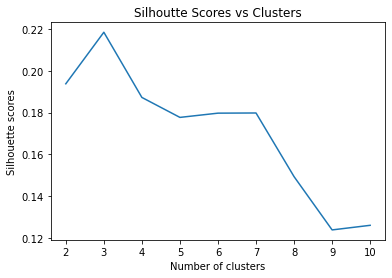

In [ ]:
X_pca = amp_lyr33_learner.pick_k()

Cluster counts: Counter({0: 1284, 1: 872, 4: 820, 2: 586, 3: 367, 5: 113})


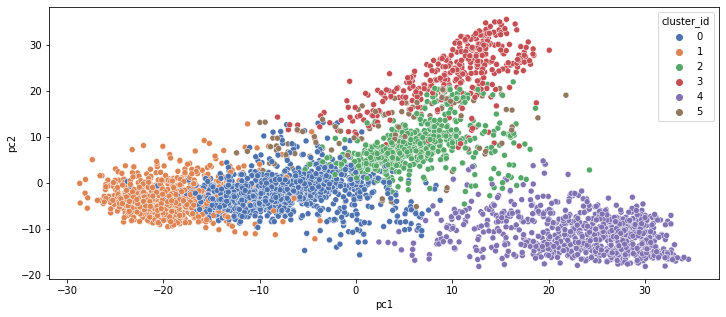

In [ ]:
amp_lyr33_learner.analyze_clusters(X_pca, k=6)

## DNA Binding Dataset

### DNA - PCA vs Full Data

In [5]:
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14189, 1280), (14189,), (2272, 1280), (2272,))

In [6]:

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(
    f"Explained variance ratio of the first 10 principal components:\n{pca.explained_variance_ratio_[:10]}"
)

X_train_pca.shape: (14189, 50)
Explained variance ratio of the first 10 principal components:
[0.20549127 0.07429418 0.03392503 0.03367167 0.02754671 0.02543028
 0.02173496 0.01814979 0.01678294 0.01414292]


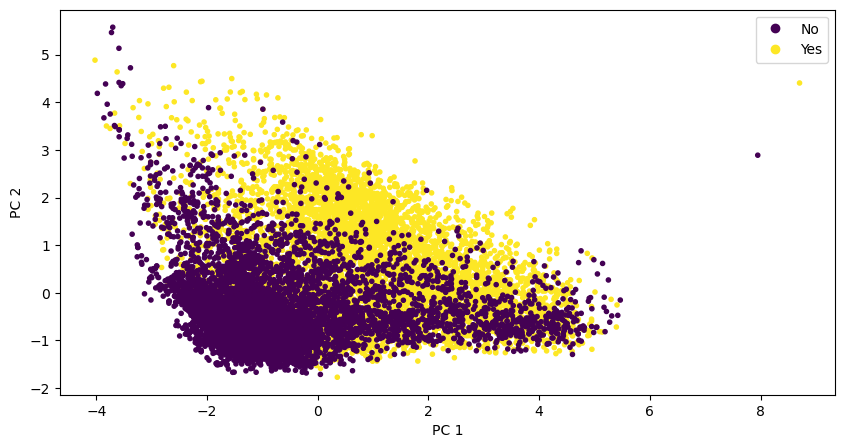

In [7]:
visualize_2pcs(X_train_pca, y_train)

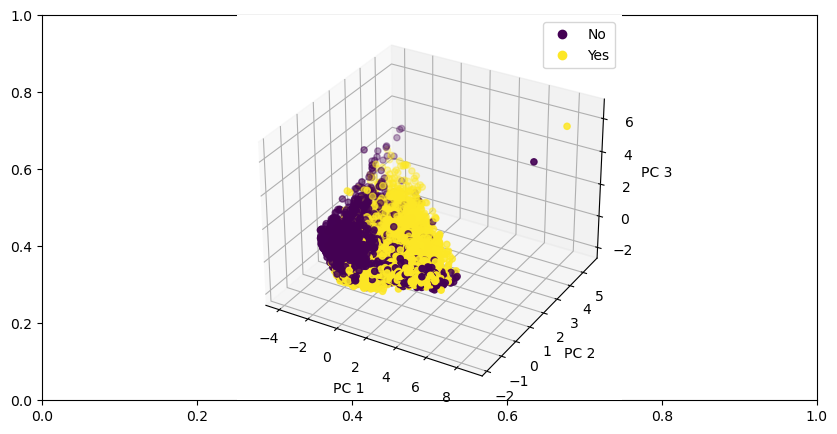

In [8]:
visualize_3pcs(X_train_pca, y_train)

Evaluation on full data

In [ ]:
train_predict(X_train, y_train, X_test, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.827465,0.897658,0.790680,0.840780
svc,0.827905,0.911535,0.784328,0.843161
xgb,0.843310,0.969644,0.776928,0.862654


Evaluation on reduced data

In [ ]:
X_test_pca = pca.transform(X_test)
train_predict(X_train_pca, y_train, X_test_pca, y_test)

/home/vinod/anaconda3/envs/peptide/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,acc,recall,precision,f1
lr,0.755282,0.843886,0.721275,0.777778
svc,0.754842,0.850824,0.718155,0.778881
xgb,0.818222,0.960104,0.751018,0.842786


### DNA - Get Data and Learners (Layer 33 vs Layer 32)

In [9]:
# layer 33 (default)
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta')
dna_lyr33_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

# layer 32
X_train, y_train, X_test, y_test = dna_data.get_transformer_emb('dna_train_seqlen_300.fasta', 'dna_test_seqlen_300.fasta', emb_layer=32)
dna_lyr32_learner = Learner(X_train, y_train, X_test, y_test, scaler=True) 

### DNA - Grid Search (Supervised Learning)

In [10]:
dna_lyr33_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [11]:
#hide_output

_, _ = dna_lyr33_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [12]:
dna_lyr32_learner.pipeline.steps

[('scaler', StandardScaler()),
 ('pca', PCA(n_components=50)),
 ('classifier', 'passthrough')]

In [13]:
#hide_output

_, _ = dna_lyr32_learner.train()

Starting grid search for LogisticRegression
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Starting grid search for LinearSVC
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinod/anaconda3/envs/peptide2

Starting grid search for XGBClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


### DNA - Label Spreading (Semi Supervised Learning)

In [14]:
dna_lyr33_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1119
           1       0.70      0.91      0.79      1153

    accuracy                           0.76      2272
   macro avg       0.79      0.76      0.75      2272
weighted avg       0.78      0.76      0.75      2272



In [15]:
dna_lyr32_learner.run_label_spreading()

              precision    recall  f1-score   support

           0       0.89      0.69      0.77      1119
           1       0.75      0.91      0.82      1153

    accuracy                           0.80      2272
   macro avg       0.82      0.80      0.80      2272
weighted avg       0.82      0.80      0.80      2272



### DNA - Prediction Results
Comparing prediction performance between `layer 33` (final) and `layer 32` embeddings

In [16]:
dna_lyr33_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.757042,0.839549,0.725094,0.778135
LinearSVC,"{'classifier': LinearSVC(max_iter=10000), 'cla...",0.751761,0.849957,0.714807,0.776545
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.828345,0.968777,0.759347,0.851372
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.759683,0.912402,0.702739,0.793962


In [17]:
dna_lyr32_learner.predict()

,best_params,accuracy,recall,precision,f1
LogisticRegression,"{'classifier': LogisticRegression(C=0.01, max_...",0.789613,0.847355,0.763878,0.803454
LinearSVC,"{'classifier': LinearSVC(loss='hinge', max_ite...",0.800616,0.862099,0.771739,0.81442
XGBClassifier,"{'classifier': XGBClassifier(base_score=None, ...",0.840669,0.961839,0.777155,0.85969
LabelSpreading,"{'alpha': 0.01, 'gamma': 20, 'kernel': 'knn', ...",0.802817,0.914137,0.751247,0.824726


Save results.

In [18]:
dna_lyr33_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/dna_transformer_lyr33_learner.csv')
dna_lyr32_learner.predict_results.to_csv(f'{EXPERIMENT_STORE}/dna_transformer_lyr32_learner.csv')

### DNA - KMeans Clustering (Unsupervised Learning)

n_clusters: 2 -- avg silhouette score: 0.10359084606170654
n_clusters: 3 -- avg silhouette score: 0.10609325766563416
n_clusters: 4 -- avg silhouette score: 0.12145189940929413
n_clusters: 5 -- avg silhouette score: 0.11041442304849625
n_clusters: 6 -- avg silhouette score: 0.11514927446842194
n_clusters: 7 -- avg silhouette score: 0.08790705353021622
n_clusters: 8 -- avg silhouette score: 0.09514793753623962
n_clusters: 9 -- avg silhouette score: 0.0954178050160408
n_clusters: 10 -- avg silhouette score: 0.095805324614048


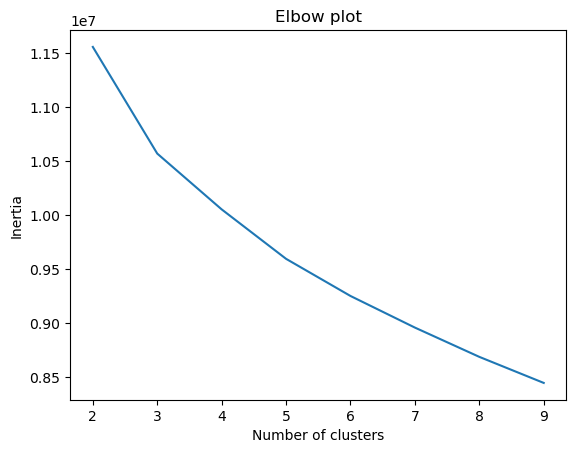

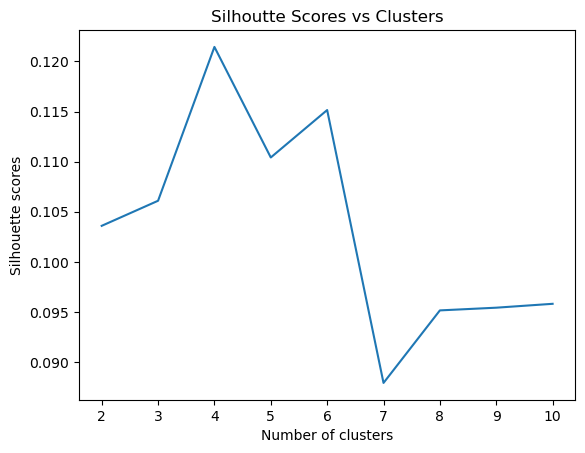

In [19]:
X_pca = dna_lyr33_learner.pick_k()

Cluster counts: Counter({2: 7224, 3: 3761, 1: 1635, 4: 1592, 5: 1297, 0: 952})


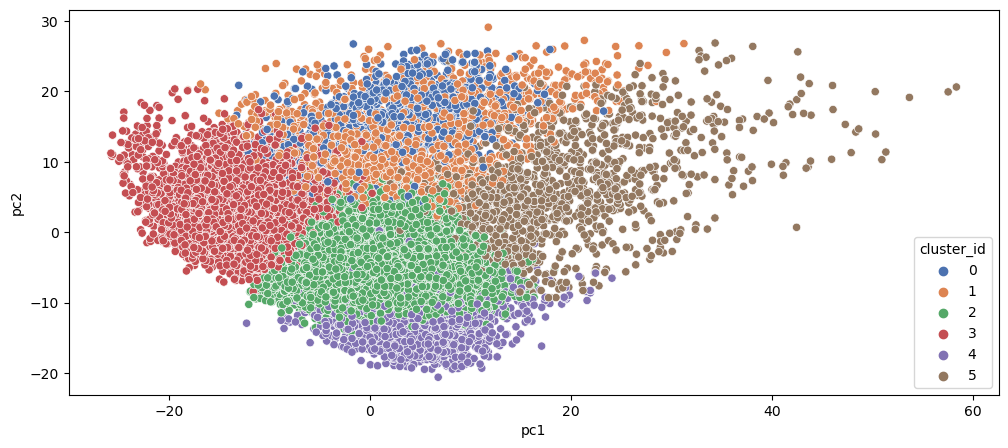

In [20]:
dna_lyr33_learner.analyze_clusters(X_pca, k=6)

## Export -

In [21]:
# hide
from nbdev.export import *

notebook2script()


Converted 00_basics.ipynb.
Converted 01_data.ipynb.
Converted 02_learn.ipynb.
Converted 03_onehot.ipynb.
Converted 04_lstm.ipynb.
Converted 05_transformer.ipynb.
Converted 99_utils.ipynb.
Converted index.ipynb.
